# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: CodeChallenge: Effects of mini-batch size
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

/tmp/ipykernel_11063/1094594094.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Things related to data

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [4]:
# Use scikit-learn to split the data into training and testing sets.
# The `train_test_split` function splits the data into training (80%) and testing (20%) sets.
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)

# Convert the training and testing data and labels into PyTorch Dataset objects.
# A PyTorch Dataset is a container for data and labels, which can be used with DataLoader for batching during training.
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# You haven't converted these datasets into DataLoader objects yet.
# DataLoader is used to iterate through the data in batches during training.
# You'll likely convert them into DataLoader objects later in your code.


# Things related to the model

In [5]:
# Define a function to create the ANN model
def createANewModel():

  # Create a Sequential model, which is a linear stack of layers.
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # Input layer with 4 input features and 64 output units
      nn.ReLU(),         # ReLU activation function
      nn.Linear(64,64),  # Hidden layer with 64 input units and 64 output units
      nn.ReLU(),         # ReLU activation function
      nn.Linear(64,3),   # Output layer with 64 input units and 3 output units (for classification)
      # nn.Softmax(dim=1), # You've commented out the softmax activation; it's often used for classification tasks.
        )

  # Define the loss function as CrossEntropyLoss, suitable for classification tasks.
  lossfun = nn.CrossEntropyLoss()

  # Define the optimizer as Stochastic Gradient Descent (SGD) with a learning rate of 0.001.
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.001)

  # Return the created model, loss function, and optimizer.
  return ANNiris, lossfun, optimizer


In [6]:
# Define a global parameter 'numepochs' with a value of 500, representing the number of training epochs.
numepochs = 500

# Define a function 'trainTheModel' to train the neural network.
def trainTheModel():

  # Initialize lists to store training and test accuracies, as well as losses during training.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Loop over epochs (training iterations).
  for epochi in range(numepochs):

    # Activate training mode for the neural network.
    ANNiris.train()

    # Initialize lists to store accuracy and loss for each batch during training.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X,y in train_loader:

      # Perform a forward pass through the neural network.
      yHat = ANNiris(X)

      # Calculate the loss using the specified loss function.
      loss = lossfun(yHat,y)
      
      # Clear previous gradient calculations.
      optimizer.zero_grad()
      
      # Perform backpropagation to compute gradients.
      loss.backward()
      
      # Update the model's parameters using the optimizer.
      optimizer.step()

      # Compute training accuracy for this batch and append to 'batchAcc'.
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      
      # Append the loss value for this batch to 'batchLoss'.
      batchLoss.append( loss.item() )
    # End of batch loop...

    # Calculate the average training accuracy for this epoch and append to 'trainAcc'.
    trainAcc.append( np.mean(batchAcc) )

    # Append the average loss for this epoch to 'losses'.
    losses.append( np.mean(batchLoss) )

    # Test accuracy on the validation set.
    
    # Extract X,y from the test dataloader.
    X,y = next(iter(test_loader))

    # Activate evaluation mode (no gradient computation) for the neural network.
    ANNiris.eval()

    # Perform forward pass for the test data.
    with torch.no_grad():
      predlabels = torch.argmax( ANNiris(X),axis=1 )
    
    # Compute accuracy on the test data and append to 'testAcc'.
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # Function output: training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses


# Run the experiment and visualize the results

In [7]:
# Define a range of batch sizes as powers of 2 from 2^1 to 2^6.
batchsizes = 2**np.arange(1,7)

# Initialize empty matrices to store training and test accuracies for different batch sizes.
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))

# The test data loader does not vary by training batch size, so it can be created outside the loop.
# It uses the same test dataset as before.
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

# Loop over different batch sizes.
for bi in range(len(batchsizes)):

  # Create a data loader object for training with the current batch size.
  train_loader = DataLoader(train_dataDataset,
                            batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # Create a new model, loss function, and optimizer.
  ANNiris, lossfun, optimizer = createANewModel()

  # Train the model using the current batch size.
  trainAcc, testAcc, losses = trainTheModel()

  # Store the training and test accuracies for this batch size in the respective matrices.
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc


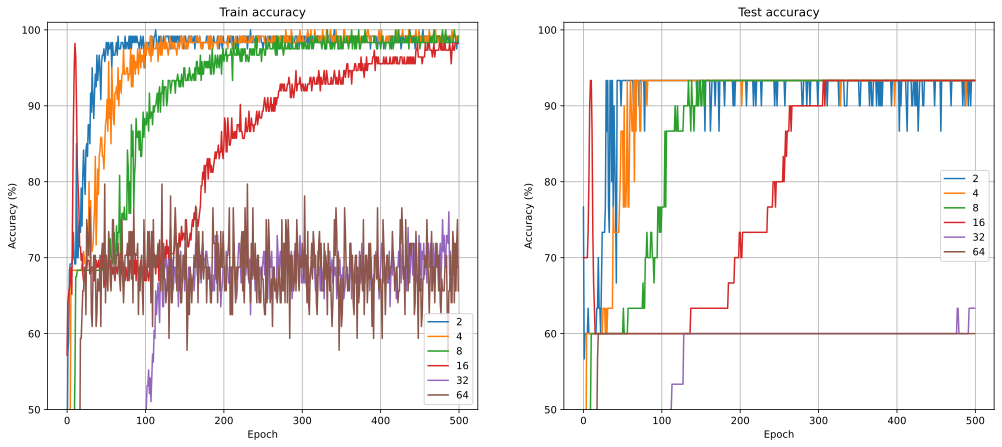

In [8]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

# Additional explorations

In [9]:
# 1) Why are the minibatch sizes specified in powers of 2? That's partly because DL is developed by math/computer nerds,
#    but it's also partly an attempt to optimize computation speed, because computer memory comes in powers of two.
#    But 2**N is not a specific requirement. Adjust the code to use batch sizes corresponding to six linearly spaced 
#    integers between 2 and 50.
# 
# 2) Why did I ask you to set the learning rate to .001? Try this experiment again using higher and lower learning rates.
#    What do you conclude about batch sizes and learning rate?
# 